In [1]:
pip install control matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 5.9 MB/s eta 0:00:00


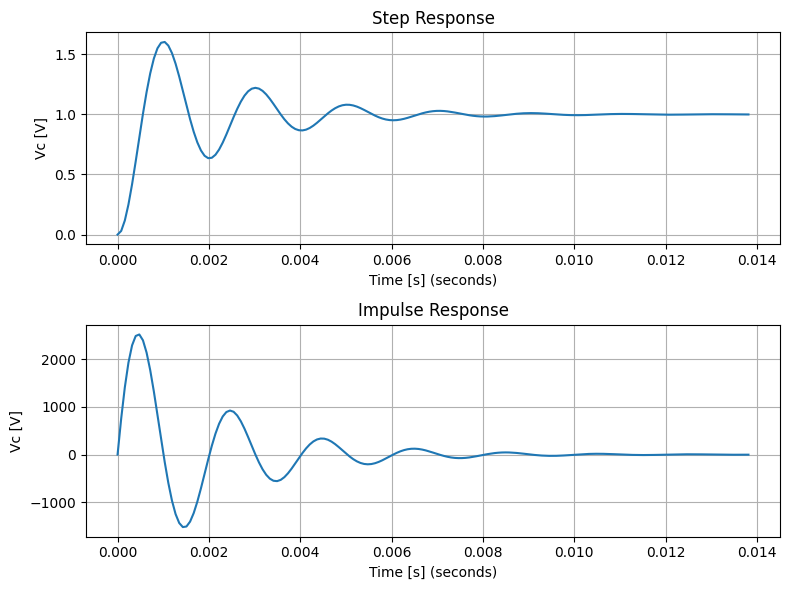

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctl

# Parámetros del circuito
R = 100      # Ohmios
L = 0.1      # Henrios
C = 1e-6     # Faradios

# Matrices del modelo en espacio de estados
A = np.array([[0, 1],
              [-1/(L*C), -R/L]])
B = np.array([[0],
              [1/L]])
C_mat = np.array([[1/C, 0]])  # Salida: voltaje en el capacitor
D = np.array([[0]])

# Crear sistema en espacio de estados
sys = ctl.ss(A, B, C_mat, D)

# Respuesta al escalón
t_step, y_step = ctl.step_response(sys)

# Respuesta al impulso
t_imp, y_imp = ctl.impulse_response(sys)

# Gráficas
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(t_step, y_step)
plt.title("Step Response")
plt.ylabel("Vc [V]")
plt.xlabel("Time [s] (seconds)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_imp, y_imp)
plt.title("Impulse Response")
plt.ylabel("Vc [V]")
plt.xlabel("Time [s] (seconds)")
plt.grid(True)

plt.tight_layout()
plt.show()

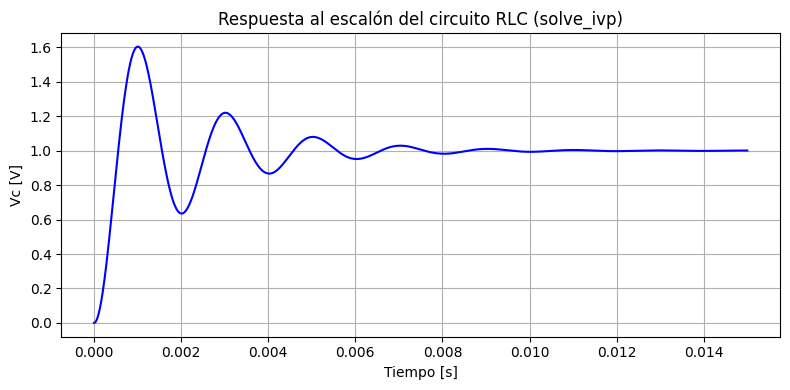

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Parámetros del circuito
R = 100       # Ohmios
L = 0.1       # Henrios
C = 1e-6      # Faradios

# Matrices del sistema
A = np.array([[0, 1],
              [-1/(L*C), -R/L]])
B = np.array([[0],
              [1/L]])
C_mat = np.array([[1/C, 0]])  # Salida: Vc
D = 0

# Función dinámica para solve_ivp
def model(t, x, A, B, u):
    return (A @ x + B.flatten() * u)

# Condiciones iniciales
x0 = [0, 0]
u = 1  # Escalón unitario

# Tiempo de simulación
t_start = 0
t_end = 0.015  # 15 ms
t_eval = np.linspace(t_start, t_end, 1000)

# Simulación con solve_ivp (Runge-Kutta similar a ode45)
sol = solve_ivp(model, [t_start, t_end], x0, args=(A, B, u), t_eval=t_eval)

# Salida: Vc = q / C = x[0] / C
y = C_mat @ sol.y

# Graficar resultado
plt.figure(figsize=(8, 4))
plt.plot(sol.t, y.T, label="Vc(t)", color="blue")
plt.title("Respuesta al escalón del circuito RLC (solve_ivp)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Vc [V]")
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import pandas as pd

# Parámetros de la señal
dt = 0.0001         # Paso de tiempo (0.1 ms)
t_max = 0.05        # Duración total (50 ms)

# Generar vector de tiempo
t = np.arange(0, t_max + dt, dt)  # desde 0 hasta 0.05 s

# Generar señal arbitraria por tramos
signal = np.zeros_like(t)
signal[(t >= 0.01) & (t < 0.02)] = 5   # 5 V entre 10 ms y 20 ms
signal[t >= 0.02] = 10                 # 10 V a partir de 20 ms

# Empaquetar en DataFrame y guardar
df = pd.DataFrame({
    'time': t,
    'input': signal
})
df.to_csv('senal_arbitraria.csv', index=False)

print(f"Señal generada: {len(t)} puntos (desde {t[0]:.4f}s hasta {t[-1]:.4f}s).")
print("Archivo guardado como 'senal_arbitraria.csv'")

Señal generada: 502 puntos (desde 0.0000s hasta 0.0501s).
Archivo guardado como 'senal_arbitraria.csv'


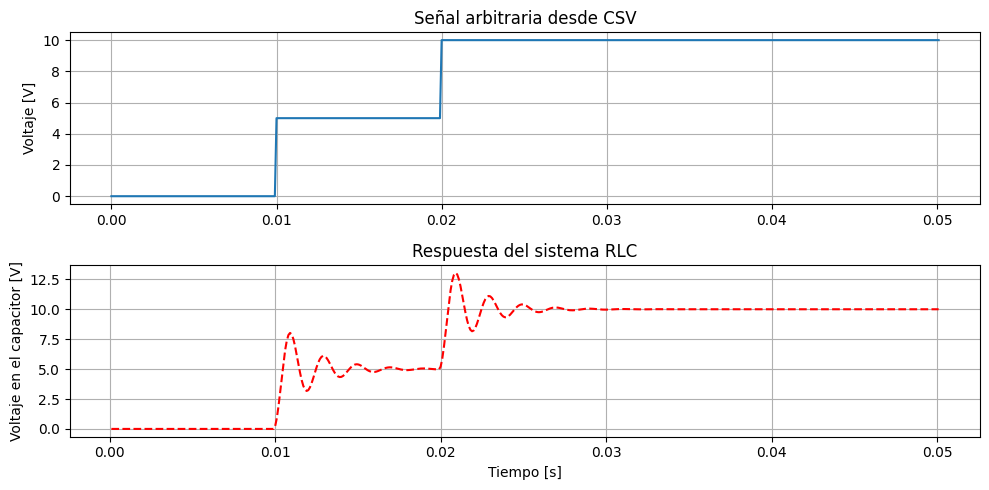

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Leer datos desde archivo CSV
data = pd.read_csv("senal_arbitraria.csv")
t_values = data["time"].values
u_values = data["input"].values

# Parámetros del circuito
R = 100       # Ohmios
L = 0.1       # Henrios
C = 1e-6      # Faradios

# Matrices del modelo en espacio de estados
A = np.array([[0, 1],
              [-1/(L*C), -R/L]])
B = np.array([[0],
              [1/L]])
C_mat = np.array([[1/C, 0]])  # Salida: voltaje del capacitor
D = 0

# Función dinámica del sistema
def model(t, x, A, B, u):
    return A @ x + B.flatten() * u

# Inicialización
x0 = [0, 0]        # Estado inicial: q(0)=0, i(0)=0
X = []             # Estados
Y = []             # Salidas
T = []             # Tiempos

# Simulación por tramos
for i in range(1, len(t_values)):
    t_span = [t_values[i-1], t_values[i]]
    u = u_values[i]
    sol = solve_ivp(model, t_span, x0, args=(A, B, u), t_eval=[t_span[1]])
    x0 = sol.y[:, -1]           # Estado final para próximo paso
    y = C_mat @ x0              # Salida = Vc = q/C
    X.append(x0)
    Y.append(y)
    T.append(t_span[1])

# Convertir resultados
Y = np.array(Y).flatten()
T = np.array(T)

# Gráficas
plt.figure(figsize=(10, 5))

plt.subplot(2,1,1)
plt.plot(t_values, u_values, label='Entrada u(t)')
plt.ylabel("Voltaje [V]")
plt.title("Señal arbitraria desde CSV")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(T, Y, '--r', label='Salida Vc(t)')
plt.xlabel("Tiempo [s]")
plt.ylabel("Voltaje en el capacitor [V]")
plt.title("Respuesta del sistema RLC")
plt.grid(True)

plt.tight_layout()
plt.show()
